In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from lstm_sine import SineData

In [2]:
%load_ext autoreload
%load_ext nb_black
%autoreload 2

<IPython.core.display.Javascript object>

In [3]:
if torch.cuda.is_available():
    device = "cuda:1"
else:
    print("Gpu not found")
    device = "cpu"

<IPython.core.display.Javascript object>

In [4]:
x = torch.arange(100, device=device)
y = np.sin(x.cpu()).to(device)
x = torch.zeros(100, 1)

<IPython.core.display.Javascript object>

In [91]:
class LSTMModel(nn.Module):
    def __init__(self, nodes=10, layers=1, memory=15):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=nodes, num_layers=layers)
        self.out = nn.Linear(nodes, 1)

    def forward(self, x):
        # print(x.shape)
        # d
        # h_n = torch.zeros(x.size(0), 1, device=device)
        # print(type(x))
        output, (h_n, c_n) = self.lstm(x)
        return self.out(h_n)

<IPython.core.display.Javascript object>

In [137]:
waves = 20
f = 8
sample = 169
future = 100
if future >= sample:
    raise ValueError("Increase sample to be > future!")
x = (
    torch.from_numpy(
        np.swapaxes(
            np.arange(0, sample)
            + np.random.randint(-2 * sample // f, 2 * sample // f, waves).reshape(
                waves, 1
            ),
            0,
            1,
        )[:, :, np.newaxis],
    )
    .float()
    .to(device)
)

x_future = x[-future:]
x = x[:-future]

y_future = torch.sin(x_future)
y = torch.sin(x)
# print(y_future.size(), y.size())

<IPython.core.display.Javascript object>

In [138]:
model = LSTMModel().to(device)
model = torch.jit.script(model)
optimizer = torch.optim.LBFGS(model.parameters(), lr=0.1)
# optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
loss_func = nn.MSELoss()
model.train()

for i in range(10):

    def closure():
        optimizer.zero_grad()
        # print(x)
        # exit()
        y_pred = model.forward(y[:-1])
        # print(y_pred.shape)
        # exit()
        loss = loss_func(y_pred, y[-1:])
        print(f"Epoch {i}: {loss.item()}")
        loss.backward()
        return loss

    loss = closure()
    # optimizer.step()
    optimizer.step(closure)

Epoch 0: 0.4517919719219208
Epoch 0: 0.4517919719219208
Epoch 0: 0.4394516944885254
Epoch 0: 0.4291163384914398
Epoch 0: 0.42047038674354553
Epoch 0: 0.41326212882995605
Epoch 0: 0.40725284814834595
Epoch 0: 0.40223127603530884
Epoch 0: 0.39801692962646484
Epoch 0: 0.3944578170776367
Epoch 0: 0.39142704010009766
Epoch 0: 0.3888187110424042
Epoch 0: 0.3865443170070648
Epoch 0: 0.38452956080436707
Epoch 0: 0.3827110230922699
Epoch 0: 0.38103386759757996
Epoch 0: 0.37944886088371277
Epoch 0: 0.37791019678115845
Epoch 0: 0.3763716518878937
Epoch 0: 0.3747834265232086
Epoch 0: 0.3730853199958801
Epoch 1: 0.371195912361145
Epoch 1: 0.371195912361145
Epoch 1: 0.36898940801620483
Epoch 1: 0.36623772978782654
Epoch 1: 0.36242300271987915
Epoch 1: 0.3557724356651306
Epoch 1: 0.3194645345211029
Epoch 1: 0.26731881499290466
Epoch 1: 0.2531869113445282
Epoch 1: 0.24337391555309296
Epoch 1: 0.21733517944812775
Epoch 1: 0.19263708591461182
Epoch 1: 0.1736048310995102
Epoch 1: 0.14881150424480438
Epoc

<IPython.core.display.Javascript object>

torch.Size([69, 20, 1]) torch.Size([100, 20, 1]) torch.Size([69, 20, 1])
20 20


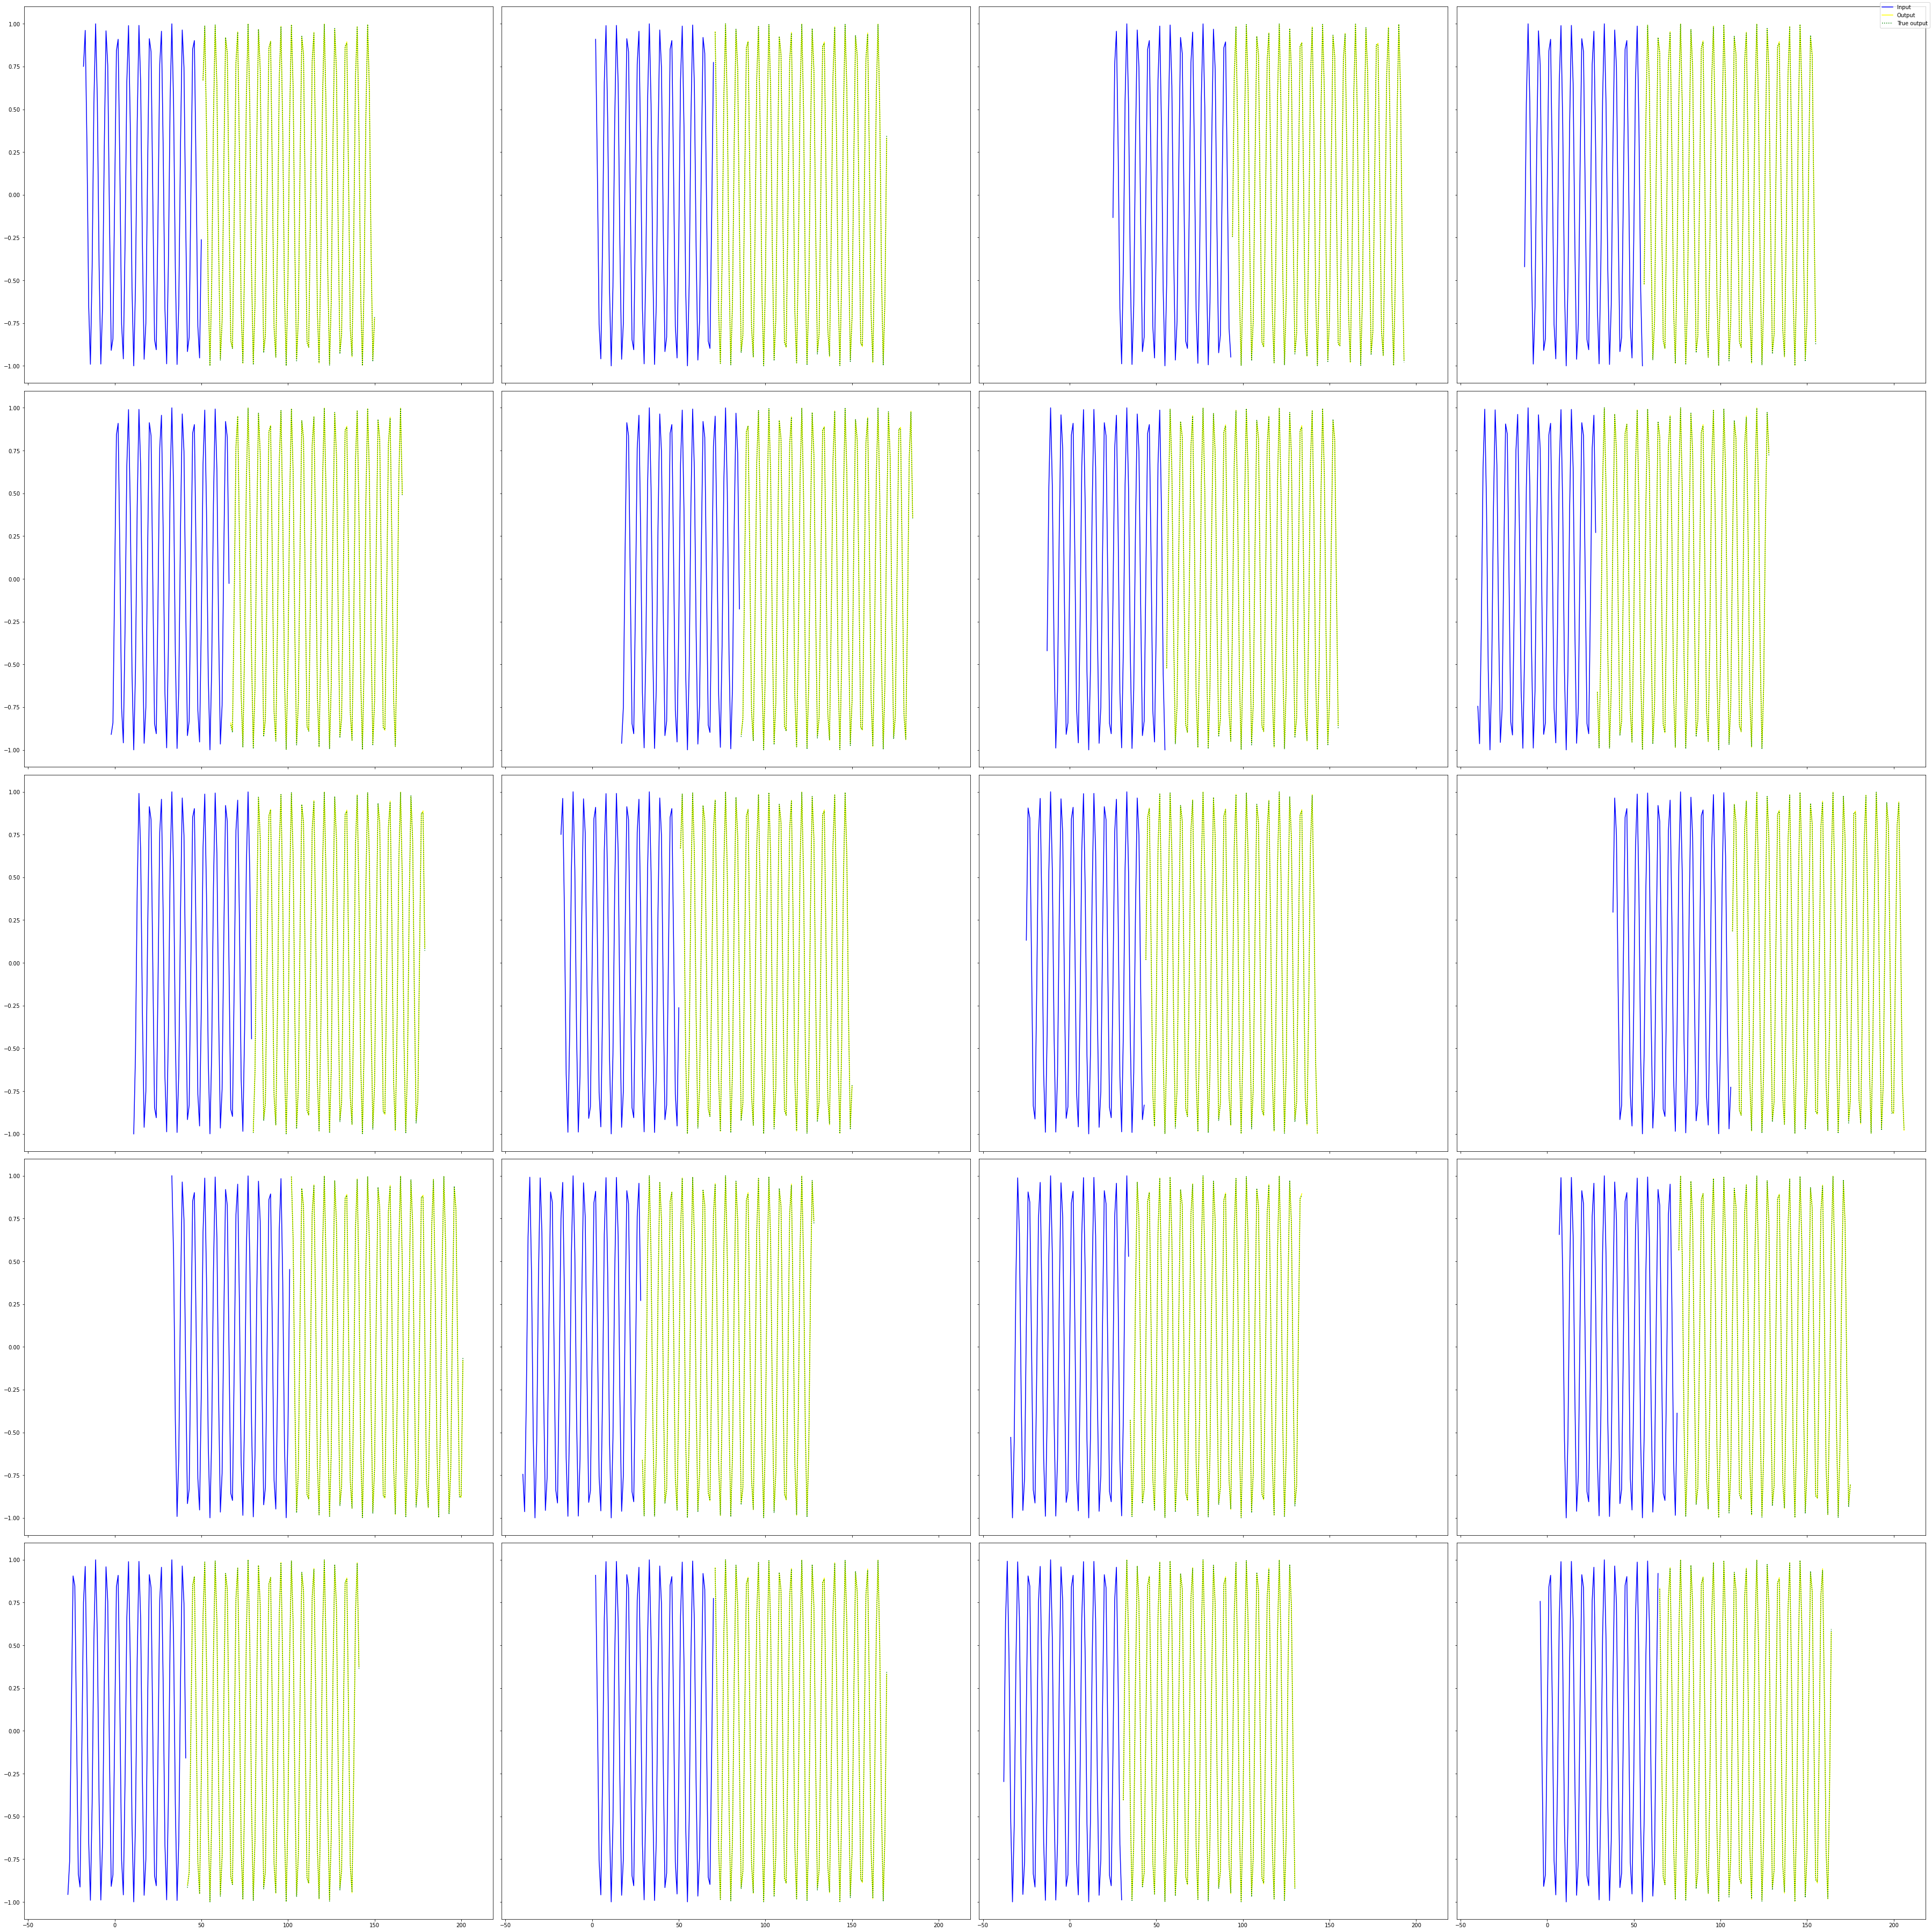

<IPython.core.display.Javascript object>

In [167]:
# sample_plot = 2
with torch.no_grad():
    y_pred = torch.zeros(y.size(0) + future, waves, 1, device=device)
    y_pred[: y.size(0)] = y
    for i in range(future):
        y_pred[y.size(0) + i] = model.forward(y_pred[: y.size(0) + i])
    y_pred = y_pred.cpu().detach()
# x_plot = np.arange(len(y_pred))
# plt.plot(x_plot[: y.size(0)], y_pred[: y.size(0), sample_plot], label="Input")
# plt.plot(x_plot[y.size(0) + 1 :], y_pred[y.size(0) + 1 :, sample_plot], label="Pred")
print(y_pred[future:].shape, x_future.shape, x.shape)
fig, ax = plt.subplots(waves // 4, 4, figsize=[50, 50], sharex=True, sharey=True)
ax = ax.flatten()
print(len(ax), waves)
for i in range(waves):
    ax[i].plot(x[:, i].cpu().detach(), y_pred[: y.size(0), i], color="blue")
    ax[i].plot(
        x_future[:, i].cpu().detach(), y_pred[y.size(0) :, i], color="yellow",
    )
    ax[i].plot(
        x_future[:, i].cpu().detach(),
        y_future[:, i].cpu().detach(),
        ":",
        color="green",
    )
# plt.plot(x_plot)
fig.legend(["Input", "Output", "True output"])
fig.tight_layout()
plt.show()